In [1]:
#import sys
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install albumentations

zsh:1: parse error near `-m'
zsh:1: parse error near `-m'
zsh:1: parse error near `-m'
zsh:1: parse error near `-m'


Importing Required Libraries

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
import numpy as np
from sklearn.model_selection import train_test_split
import os
import cv2
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import albumentations as A
from albumentations import (
    Compose, RandomRotate90, VerticalFlip, Transpose,
    OneOf, GaussNoise, RandomBrightnessContrast
)

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Importing Data from 'Train' folder 

In [3]:
# Importing data from the 'Train' Folder
data = r'Train'
# Creating empty list to store filenames
files = []
# Iterating through the data and storing the filenames in the files list
for _, _, files in os.walk(data):
    break
# Printing the total number of images currently being used to train and test the models below
print(f'Total number of files: {len(files)}')


Total number of files: 971


In [19]:
#Bootstrap function : Perform bootstrapping on a list of images and return the new bootstrap list
def bootstrap(imageList, n_samples):
    result = [np.random.choice(imageList) for _ in range(n_samples)]

    return result

#Defining the data augmentation transform variable
transforms = Compose([
    RandomRotate90(p=0.5),
    VerticalFlip(p=0.5),
    OneOf([
        GaussNoise(),
        RandomBrightnessContrast(),
    ], p=0.5),
])

def bootstrap_and_augment(imageList, n_sample):
    bootstrap_images = bootstrap(imageList=imageList, n_samples=n_sample)

    for image in bootstrap_images:
        # Create multiple augmentations per bootstrapped image
        n_augmentations = 2  # Number of augmentations per image
        
        for _ in range(n_augmentations):
            augmented = transforms(image=image)['image']
            bootstrap_images.append(augmented)
    return bootstrap_images


In [5]:
bootstrap_images_sample_size_5000 = bootstrap(files,1000)
bootstrap_images_sample_size_10000 = bootstrap(files,10000)

In [20]:
bootstrap_and_augment_size_1000 = bootstrap_and_augment(files, 1000)

TypeError: image must be numpy array type

Classifying the images based on the labels in the filename

Something to note, I originally created the array of just size 1 that stored the value of each label in that single spot as 0,1,2 but it resulted in accuracy ratings never changing between epochs and being lower after trying different techniques this is the current attempt that is having the best results, currently values are stored in a numpy array of size 3 where the first value being 1 represents a lower class, the second being 1 represents middle and the third being 1 represents upper class.

What Y looks like
Y = ([[1. 0. 0.], [0. 1. 0.], [0. 0. 1.]])

In [6]:

def image_label_classification( files):
    # Creating a numpy array of zeros the length of the dataset with a size of shape of 3
    Y = np.zeros((len(files), 3))

    # Loop through the list of filenames
    for i, f in enumerate(files):

        # If the filename contains 'lower' set the first value of the array to 1
        if 'lower' in f:
            Y[i, 0] = 1  
        # If the filename contains 'middle' set the second value of the array to 1
        elif 'middle' in f:
            Y[i, 1] = 1  
        # If the filename contains 'upper' set the third value of the array to 1
        elif 'upper' in f:
            Y[i, 2] = 1  

    #Create the path to each file 
    files = [os.path.join(data, f) for f in files]

    #Example showing the path to the file and the coorisponding label showing what we have classified as middle in the numpy array.
    print(f'File location: {files[1]}\n Classified as: {Y[1]}')
    # Printing the total number of images currently being used to train and test the models below
    print(f'Total number of files: {len(files)}')
    print(f'Total number of Y: {len(Y)}')
    return files,Y

In [7]:
#Raw image files and Calling the image_label_classification funciton to classify the images based on the labels in the filename
files, Y = image_label_classification(files)

#5000 bootstrap image files and Calling the image_label_classification funciton to classify the images based on the labels in the filename
files_bootstrap_images_sample_size_5000, Y2 = image_label_classification(bootstrap_images_sample_size_5000)

#10000 bootstrap image files and Calling the image_label_classification funciton to classify the images based on the labels in the filename
files_bootstrap_images_sample_size_10000, Y3 = image_label_classification(bootstrap_images_sample_size_10000)


File location: Train/img569_lower.jpg
 Classified as: [1. 0. 0.]
Total number of files: 971
Total number of Y: 971
File location: Train/img1357_lower.png
 Classified as: [1. 0. 0.]
Total number of files: 1000
Total number of Y: 1000
File location: Train/img292_lower.jpg
 Classified as: [1. 0. 0.]
Total number of files: 10000
Total number of Y: 10000


# Creating a Sequential model 
This runs for multiple image sizes to determine the Evaluation scores based on image size

In [8]:
# List of image sizes
#image_size = [(16, 16), (32, 32), (64, 64), (150, 150), (250, 250), (500, 500)]
image_size = [(64, 64), (150, 150), (250, 250)]


# Epoch count, currently anything over 5 epochs does not result in any change in the accuracy rating
epochs = 2

# Creating a list to store the image sizes and accuracy ratings for the Sequential Model
conv_accuracy_results = []
def create_sequential_model(image_size, files, Y):
    
    # Looping through each image size
    for size in image_size:

        # Creating a list of each images numerical values
        X = []

        for file in files:
            img = cv2.imread(file) 
            # Resizing the image based on the specific tuple in image_sizes
            img = cv2.resize(img, size) 
            X.append(img)

        # Scaling the image data down to values between 0 and 1
        X = np.array(X, dtype='float32') / 255

        # Train Test Split to split up the data into training and testing datasets with a current size of 80% training 20% testing data
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=38)

        # Creating a Sequential Convolution Neural Network model with 2 layers
        model = models.Sequential([
        layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (size[0], size[1], 3)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, (3,3), activation='relu', input_shape = (size[0], size[1], 3)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        # Dense layer of size 3 to match the input size of the numpy array Y
        layers.Dense(3, activation='softmax')
        ])

        # Compiling the model utilizing the adam optimizer and categorical crossentropy 
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Fitting the model based on the TrainTestSplit data and epochs set from the value epochs
        model.fit(X_train, Y_train, epochs=epochs, batch_size=64, validation_split=0.2)
        
        # Predicting the outputs of the test data using the model
        y_pred = model.predict(X_test)

        # Converting the One-Hot labels into class indices so they can be used to for evaluation
        Y_test_classes = np.argmax(Y_test, axis=1)
        Y_pred_classes = np.argmax(y_pred, axis = 1)

        # Calculating Evaluation Metrics
        accuracy = accuracy_score(Y_test_classes, Y_pred_classes)
        precision = precision_score(Y_test_classes,Y_pred_classes, average='weighted', zero_division=1)
        recall = recall_score(Y_test_classes,Y_pred_classes, average='weighted', zero_division=1)
        f1 = f1_score(Y_test_classes,Y_pred_classes, average='weighted', zero_division=1)
        classification_rep = classification_report(Y_test_classes,Y_pred_classes)
        
        # Appending all the evaluation metrics into the conv_accuracy_results list
        conv_accuracy_results.append((size, accuracy, precision, recall, f1, classification_rep))

        # Printing the Classification Report for that image size
        print(f'Image Size: {size}')
        print(classification_rep)
    

In [9]:
# Creating variables for each item in conv_accuracy_results
def create_accuracy_rating_graph():
    sizes, acc, prec, recall, f1, classrep = zip(*conv_accuracy_results)

    # Converting the image sizes into a string so they can be used for the X axis
    sizes = [str(size) for size in sizes]

    # Plot showing the Evaluation Metrics vs Image Size
    plt.plot(sizes, acc, marker='o', color = 'g', label = 'Accuracy Score')
    # Not using recall as it is identical to the accuracy rating when tested currently
    #plt.plot(sizes, recall, marker='o', color = 'r', label = 'Recall Score')
    plt.plot(sizes, prec, marker='o', color = 'y', label = 'Precision Score')
    plt.plot(sizes, f1, marker='o', color = 'b', label = 'f1 Score')
    plt.title('Evaluation Metrics vs Image Size for CNN')
    plt.xlabel('Image Size')
    plt.ylabel('Evaluation Score')
    plt.legend()
    plt.grid()
    plt.show()

In [10]:

create_sequential_model(image_size=image_size,files=files,Y=Y)

Epoch 1/5


/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.4186 - loss: 1.0603 - val_accuracy: 0.4295 - val_loss: 1.0292
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4495 - loss: 1.0078 - val_accuracy: 0.4231 - val_loss: 1.0334
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5068 - loss: 0.9879 - val_accuracy: 0.4936 - val_loss: 1.0091
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5406 - loss: 0.9236 - val_accuracy: 0.5000 - val_loss: 1.0319
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5524 - loss: 0.9423 - val_accuracy: 0.4936 - val_loss: 1.0452
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Image Size: (64, 64)
              precision    recall  f1-score   support

           0       0.51      0.70      0.59        88
           1       0.51      0.44      0.47        84
           2       0.00      0.00      0.00        23

    accuracy                           0.51       195
   macro avg       0.34      0.38      0.35      

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Epoch 1/5


/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.4386 - loss: 2.6193 - val_accuracy: 0.4038 - val_loss: 1.1062
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.4339 - loss: 1.0905 - val_accuracy: 0.4038 - val_loss: 1.0590
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.4535 - loss: 1.0152 - val_accuracy: 0.4038 - val_loss: 1.0513
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.4614 - loss: 0.9684 - val_accuracy: 0.4679 - val_loss: 1.0260
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.6038 - loss: 0.8995 - val_accuracy: 0.4808 - val_loss: 1.0305
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Image Size: (150, 150)
              precision    recall  f1-score   support

           0       0.54      0.17      0.26        88
           1       0.45      0.89      0.60        84
           2       0.00      0.00      0.00        23

    accuracy                           0.46       195
   macro avg       0.33      0.35      0.2

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Epoch 1/5


/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 421ms/step - accuracy: 0.4646 - loss: 8.1556 - val_accuracy: 0.4038 - val_loss: 1.0935
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 402ms/step - accuracy: 0.4048 - loss: 1.0758 - val_accuracy: 0.4295 - val_loss: 1.0778
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 403ms/step - accuracy: 0.4085 - loss: 1.0433 - val_accuracy: 0.4359 - val_loss: 1.0265
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 408ms/step - accuracy: 0.5505 - loss: 0.9358 - val_accuracy: 0.4423 - val_loss: 1.0633
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 403ms/step - accuracy: 0.6083 - loss: 0.8714 - val_accuracy: 0.4808 - val_loss: 1.0710
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Image Size: (250, 250)
              precision    recall  f1-score   support

           0       0.56      0.16      0.25        88
           1       0.45      0.90      0.60        84
           2       0.00      0.00      0.00        23

    accuracy                           0.46       195
   macro avg       0.34      0.35      0.2

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Epoch 1/5


/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.3441 - loss: 19.8579 - val_accuracy: 0.4295 - val_loss: 1.1810
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.4226 - loss: 1.1122 - val_accuracy: 0.5000 - val_loss: 1.0944
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5226 - loss: 1.1071 - val_accuracy: 0.4423 - val_loss: 1.0703
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5328 - loss: 0.9648 - val_accuracy: 0.4744 - val_loss: 1.0896
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7479 - loss: 0.7126 - val_accuracy: 0.4615 - val_loss: 1.2012
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step
Image Size: (500, 500)
              precision    recall  f1-score   support

           0       0.45      0.68      0.55        88
           1       0.49      0.37      0.42        84
           2       0.00      0.00      0.00        23

    accuracy                           0.47       195
   macro avg       0.32      0.35      0.32       

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

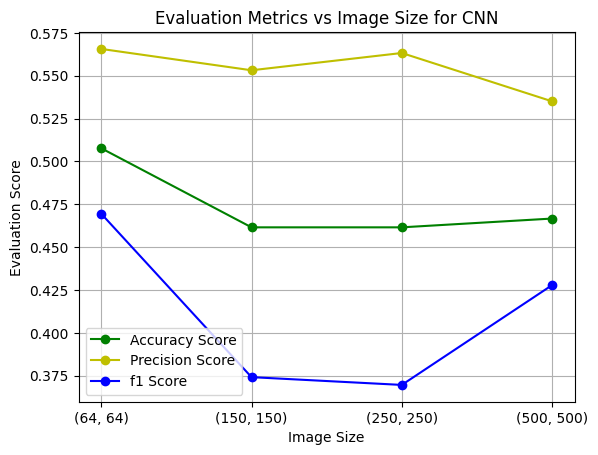

In [11]:
create_accuracy_rating_graph()

In [12]:
conv_accuracy_results = []
create_sequential_model(image_size=image_size,files=files_bootstrap_images_sample_size_5000,Y=Y2)

Epoch 1/5


/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.4491 - loss: 1.1028 - val_accuracy: 0.4250 - val_loss: 1.0065
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4543 - loss: 0.9860 - val_accuracy: 0.4875 - val_loss: 0.9748
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5504 - loss: 0.9599 - val_accuracy: 0.4938 - val_loss: 0.9834
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5979 - loss: 0.9281 - val_accuracy: 0.4750 - val_loss: 0.9813
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6121 - loss: 0.8534 - val_accuracy: 0.5375 - val_loss: 0.9693
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Image Size: (64, 64)
              precision    recall  f1-score   support

           0       0.65      0.34      0.45        87
           1       0.44      0.85      0.58        79
           2       0.00      0.00      0.00        34

    accuracy                           0.48       200
   macro avg       0.36      0.40      0.34      

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Epoch 1/5


/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.3574 - loss: 1.8873 - val_accuracy: 0.4938 - val_loss: 1.0824
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.5976 - loss: 1.0402 - val_accuracy: 0.4875 - val_loss: 0.9752
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.5470 - loss: 0.8935 - val_accuracy: 0.5375 - val_loss: 0.9054
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.6930 - loss: 0.7564 - val_accuracy: 0.6375 - val_loss: 0.9282
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.7541 - loss: 0.5966 - val_accuracy: 0.6500 - val_loss: 0.7705
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Image Size: (150, 150)
              precision    recall  f1-score   support

           0       0.64      0.71      0.67        87
           1       0.65      0.81      0.72        79
           2       1.00      0.12      0.21        34

    accuracy                           0.65       200
   macro avg       0.76      0.55      0.5

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 432ms/step - accuracy: 0.4711 - loss: 7.5316 - val_accuracy: 0.4500 - val_loss: 1.0809
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 421ms/step - accuracy: 0.4745 - loss: 1.0574 - val_accuracy: 0.5250 - val_loss: 1.0402
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 420ms/step - accuracy: 0.5621 - loss: 0.9942 - val_accuracy: 0.4750 - val_loss: 0.9626
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 420ms/step - accuracy: 0.5902 - loss: 0.9286 - val_accuracy: 0.5125 - val_loss: 0.9530
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 422ms/step - accuracy: 0.6828 - loss: 0.8177 - val_accuracy: 0.5625 - val_loss: 0.9159
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Image Size: (250, 250)
              precision    recall  f1-score   support

           0       0.66      0.31      0.42        87
           1       0.45      0.90      0.60        79
           2       0.00      0.00      0.00        34

    accuracy                           0.49       200
   macro avg       0.37      0.40      0.3

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Epoch 1/5


/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.4356 - loss: 39.9038 - val_accuracy: 0.4500 - val_loss: 1.9426
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.4571 - loss: 1.3359 - val_accuracy: 0.5750 - val_loss: 0.9846
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7445 - loss: 0.8196 - val_accuracy: 0.6250 - val_loss: 0.7732
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8522 - loss: 0.4375 - val_accuracy: 0.6938 - val_loss: 0.7164
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9527 - loss: 0.1817 - val_accuracy: 0.7500 - val_loss: 0.7064
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step
Image Size: (500, 500)
              precision    recall  f1-score   support

           0       0.78      0.75      0.76        87
           1       0.70      0.90      0.78        79
           2       1.00      0.44      0.61        34

    accuracy                           0.76       200
   macro avg       0.83      0.70      0.72       

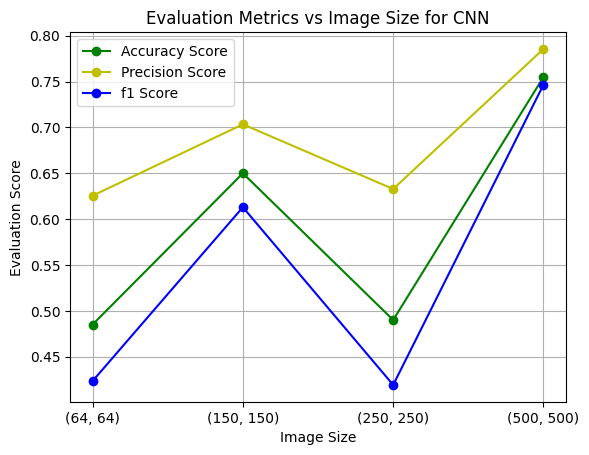

In [13]:
create_accuracy_rating_graph()

# Graphing the Accuracy Ratings
Something to note and look at later, I have ran this multiple times and each output is significantly different, sometimes prefering a smaller image size and sometimes prefering larger.

# Creating the ResNet Model
This runs for multiple image sizes to determine the Evaluation Scores based on image size

In [14]:
# List of image sizes
image_size = [(64, 64), (150, 150), (250, 250)]

# Epoch count, currently set to 5
epochs = 2

# Creating a list to store the image sizes and accuracy ratings for the ResNet model
resNet_accuracy_results = []

def create_resNetModel(image_size, files, Y):
    # Looping through each image size
    for size in image_size:
        # Creating a list of each images numerical values
        X = []

        for file in files:
            img = cv2.imread(file) 
            # Resizing the image based on the specific tuple in image_sizes
            img = cv2.resize(img, (size[0], size[1]))  
            X.append(img)

        # Scaling the image data down to values between 0 and 1
        X = np.array(X, dtype='float32') / 255.0
        
        # Train Test Split to split up the data into training and testing datasets with a current size of 80% training 20% testing data
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=38)

        # Creating a ResNet50V2 model, weights are based off the imagenet dataset and the input shape is set to the image size, currently only doing two layers
        resbase = applications.ResNet50V2(weights = 'imagenet', include_top=False, input_shape= (size[0], size[1], 3))
        # Allows only the new layers to be trainable
        resbase.trainable = False
        # Creating the sequential model utilziing the ResNet model instantiated before and adding more layers to be trained based on the current dataset
        # Currently attempting with only 1 extra layer
        resModel = models.Sequential([
            # Calling the resbase which was assigned to the ResNet model created before
            resbase,

            # Adding our extra layers to be trained
            layers.GlobalAveragePooling2D(),
            layers.Dense(256, activation= 'relu', input_shape = (size[0], size[1], 3)),
            
            # Dense layer of size 3 to match the input size of the numpy array Y
            layers.Dense(3, activation='softmax')
        ])
        
        # Compiling the model utilizing the adam optimizer and categorical crossentropy 
        resModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
        # Fitting the model based on the TrainTestSplit data and epochs set from the value epochs
        resModel.fit(X_train, Y_train, epochs = epochs, batch_size=64, validation_split=0.2)

        # Predicting the outputs of the test data using the model
        y_pred = resModel.predict(X_test)
        
        # Converting the One-Hot labels into class indices so they can be used to for evaluation
        Y_test_classes = np.argmax(Y_test, axis=1)
        Y_pred_classes = np.argmax(y_pred, axis = 1)
        
        # Calculating Evaluation Metrics
        accuracy = accuracy_score(Y_test_classes, Y_pred_classes)
        precision = precision_score(Y_test_classes,Y_pred_classes, average='weighted', zero_division=0)
        recall = recall_score(Y_test_classes,Y_pred_classes, average='weighted', zero_division=0)
        f1 = f1_score(Y_test_classes,Y_pred_classes, average='weighted', zero_division=0)
        classification_rep = classification_report(Y_test_classes,Y_pred_classes)

        # Appending all the evaluation metrics into the resNet_accuracy_results list
        resNet_accuracy_results.append((size, accuracy, precision, recall, f1, classification_rep))

        # Printing the Classification Report for that image size
        print(f'Image Size: {size}')
        print(classification_rep)

# Graphing the Accuracy Ratings of the ResNet Model

In [15]:
def create_resnet_accuracy_rating_graph():
    # Creating variables for each item in conv_accuracy_results
    sizes, acc, prec, recall, f1, classrep = zip(*resNet_accuracy_results)

    # Converting the image sizes into a string so they can be used for the X axis
    sizes = [str(size) for size in sizes]

    # Plot showing the Evaluation Metrics compared to Image size
    plt.plot(sizes, acc, marker='o', color = 'g', label = 'Accuracy Score')
    # Not using recall as it is identical to the accuracy rating when tested currently
    #plt.plot(sizes, recall, marker='o', color = 'r', label = 'Recall Score')
    plt.plot(sizes, prec, marker='o', color = 'y', label = 'Precision Score')
    plt.plot(sizes, f1, marker='o', color = 'b', label = 'f1 Score')
    plt.title('Evaluation Metrics vs Image Size for ResNet')
    plt.xlabel('Image Size')
    plt.ylabel('Evaluation Score')
    plt.legend()
    plt.grid()
    plt.show()

Epoch 1/5


/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.4027 - loss: 1.0574 - val_accuracy: 0.4487 - val_loss: 1.0726
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5748 - loss: 0.9073 - val_accuracy: 0.4744 - val_loss: 1.0729
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.6464 - loss: 0.8388 - val_accuracy: 0.4551 - val_loss: 1.0555
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.6633 - loss: 0.7977 - val_accuracy: 0.4744 - val_loss: 1.0518
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.7133 - loss: 0.7320 - val_accuracy: 0.4359 - val_loss: 1.0692
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
Image Size: (32, 32)
              precision    recall  f1-score   support

           0       0.57      0.65      0.61        88
           1       0.52      0.57      0.55        84
           2       0.33      0.04      0.08        23

    accuracy                           0.54       195
   macro avg       0.48      0.42      0.41    

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.4336 - loss: 1.5386 - val_accuracy: 0.4038 - val_loss: 1.3978
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.6673 - loss: 0.7496 - val_accuracy: 0.4359 - val_loss: 1.3138
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.8183 - loss: 0.4797 - val_accuracy: 0.4615 - val_loss: 1.3590
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.9041 - loss: 0.3654 - val_accuracy: 0.4359 - val_loss: 1.4647
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.9518 - loss: 0.2497 - val_accuracy: 0.4295 - val_loss: 1.5146
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step
Image Size: (64, 64)
              precision    recall  f1-score   support

           0       0.53      0.58      0.55        88
           1       0.42      0.43      0.43        84
           2       0.29      0.17      0.22        23

    accuracy                           0.47       195
   macro avg       0.41      0.39      0.40

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 502ms/step - accuracy: 0.4580 - loss: 1.7064 - val_accuracy: 0.4295 - val_loss: 1.3238
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 442ms/step - accuracy: 0.5627 - loss: 0.9128 - val_accuracy: 0.4872 - val_loss: 1.0636
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 444ms/step - accuracy: 0.6784 - loss: 0.7751 - val_accuracy: 0.5321 - val_loss: 1.0186
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 441ms/step - accuracy: 0.7483 - loss: 0.6336 - val_accuracy: 0.5000 - val_loss: 1.0787
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 444ms/step - accuracy: 0.8257 - loss: 0.4717 - val_accuracy: 0.4808 - val_loss: 1.0780
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 258ms/step
Image Size: (150, 150)
              precision    recall  f1-score   support

           0       0.57      0.64      0.60        88
           1       0.53      0.54      0.53        84
           2       0.17      0.09      0.11        23

    accuracy                           0.53       195
   macro avg       0.42      0.42      0.

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4230 - loss: 1.2703 - val_accuracy: 0.4295 - val_loss: 1.0785
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6794 - loss: 0.7326 - val_accuracy: 0.5449 - val_loss: 1.0266
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7759 - loss: 0.5643 - val_accuracy: 0.4744 - val_loss: 1.1518
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8187 - loss: 0.4556 - val_accuracy: 0.5321 - val_loss: 1.1088
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8282 - loss: 0.4038 - val_accuracy: 0.4872 - val_loss: 1.1411
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 463ms/step
Image Size: (250, 250)
              precision    recall  f1-score   support

           0       0.65      0.41      0.50        88
           1       0.50      0.75      0.60        84
           2       0.43      0.26      0.32        23

    accuracy                           0.54       195
   macro avg       0.53      0.47      0.48       1

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.4151 - loss: 1.3425 - val_accuracy: 0.4359 - val_loss: 0.9968
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.5717 - loss: 0.9098 - val_accuracy: 0.4872 - val_loss: 0.9485
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.6719 - loss: 0.7896 - val_accuracy: 0.5000 - val_loss: 0.9433
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.7314 - loss: 0.6822 - val_accuracy: 0.4615 - val_loss: 1.0087
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.7319 - loss: 0.6617 - val_accuracy: 0.4808 - val_loss: 1.0714
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
Image Size: (500, 500)
              precision    recall  f1-score   support

           0       0.53      0.84      0.65        88
           1       0.63      0.37      0.47        84
           2       1.00      0.26      0.41        23

    accuracy                           0.57       195
   macro avg       0.72      0.49      0.51       195

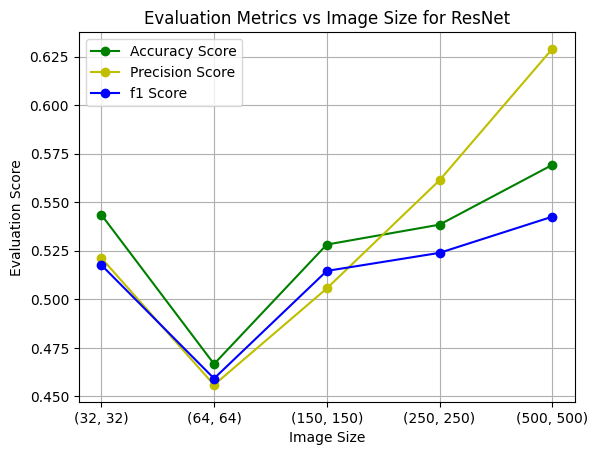

In [16]:
create_resNetModel(image_size=image_size,files=files,Y=Y)
create_resnet_accuracy_rating_graph()

Epoch 1/5


/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.4188 - loss: 1.0559 - val_accuracy: 0.5688 - val_loss: 0.9269
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.6405 - loss: 0.8585 - val_accuracy: 0.6000 - val_loss: 0.8968
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.6752 - loss: 0.8041 - val_accuracy: 0.6125 - val_loss: 0.8723
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.7252 - loss: 0.7188 - val_accuracy: 0.6187 - val_loss: 0.8544
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.7341 - loss: 0.6780 - val_accuracy: 0.6313 - val_loss: 0.8349
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
Image Size: (32, 32)
              precision    recall  f1-score   support

           0       0.65      0.71      0.68        87
           1       0.60      0.76      0.67        79
           2       1.00      0.15      0.26        34

    accuracy                           0.64       200
   macro avg       0.75      0.54      0.54    

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.4175 - loss: 1.4727 - val_accuracy: 0.6000 - val_loss: 0.9093
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.7295 - loss: 0.6060 - val_accuracy: 0.6313 - val_loss: 0.8060
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.8529 - loss: 0.4125 - val_accuracy: 0.7750 - val_loss: 0.6918
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.9213 - loss: 0.2559 - val_accuracy: 0.7563 - val_loss: 0.6675
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.9611 - loss: 0.1871 - val_accuracy: 0.7625 - val_loss: 0.6347
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step
Image Size: (64, 64)
              precision    recall  f1-score   support

           0       0.83      0.72      0.77        87
           1       0.64      0.85      0.73        79
           2       0.84      0.47      0.60        34

    accuracy                           0.73       200
   macro avg       0.77      0.68      0.70

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 508ms/step - accuracy: 0.5058 - loss: 1.2091 - val_accuracy: 0.6125 - val_loss: 0.9256
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 450ms/step - accuracy: 0.6871 - loss: 0.6923 - val_accuracy: 0.6562 - val_loss: 0.7912
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 451ms/step - accuracy: 0.8504 - loss: 0.4365 - val_accuracy: 0.7188 - val_loss: 0.6796
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 455ms/step - accuracy: 0.9243 - loss: 0.2901 - val_accuracy: 0.7250 - val_loss: 0.6686
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 451ms/step - accuracy: 0.9622 - loss: 0.1962 - val_accuracy: 0.7500 - val_loss: 0.6263
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step
Image Size: (150, 150)
              precision    recall  f1-score   support

           0       0.78      0.71      0.75        87
           1       0.64      0.82      0.72        79
           2       0.89      0.50      0.64        34

    accuracy                           0.72       200
   macro avg       0.77      0.68      0.

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5042 - loss: 1.2614 - val_accuracy: 0.6125 - val_loss: 0.8381
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6886 - loss: 0.7187 - val_accuracy: 0.6875 - val_loss: 0.7494
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7957 - loss: 0.5406 - val_accuracy: 0.7750 - val_loss: 0.6461
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8755 - loss: 0.3952 - val_accuracy: 0.7812 - val_loss: 0.5907
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9021 - loss: 0.3199 - val_accuracy: 0.7812 - val_loss: 0.5953
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 503ms/step
Image Size: (250, 250)
              precision    recall  f1-score   support

           0       0.80      0.74      0.77        87
           1       0.64      0.86      0.73        79
           2       1.00      0.38      0.55        34

    accuracy                           0.72       200
   macro avg       0.81      0.66      0.68       2

/Users/dornlee/CodeBase/Fridges/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.4807 - loss: 1.0825 - val_accuracy: 0.5750 - val_loss: 0.8985
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.6480 - loss: 0.7886 - val_accuracy: 0.6687 - val_loss: 0.8236
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.7603 - loss: 0.6803 - val_accuracy: 0.7125 - val_loss: 0.7133
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.8036 - loss: 0.5776 - val_accuracy: 0.7250 - val_loss: 0.6774
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.8244 - loss: 0.5295 - val_accuracy: 0.7000 - val_loss: 0.6789
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step
Image Size: (500, 500)
              precision    recall  f1-score   support

           0       0.82      0.56      0.67        87
           1       0.56      0.94      0.70        79
           2       1.00      0.24      0.38        34

    accuracy                           0.66       200
   macro avg       0.79      0.58      0.58       200

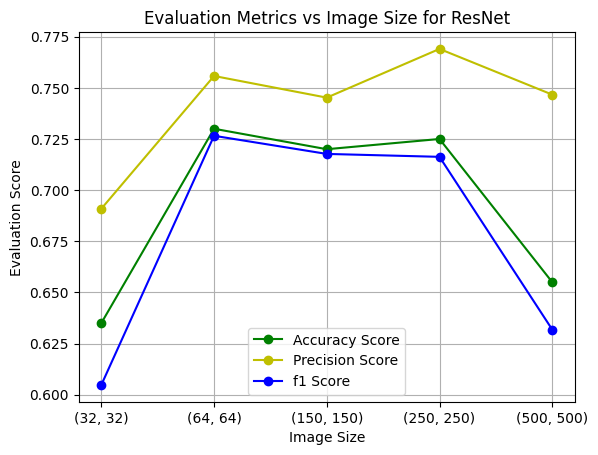

In [17]:
resNet_accuracy_results = []
create_resNetModel(image_size=image_size,files=files_bootstrap_images_sample_size_5000,Y=Y2)
create_resnet_accuracy_rating_graph()